# Applying SHRED to the Mice Dataset 

Dataset obtained from Allen Brain Atlas https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

Goal: Reconstruct LFP potential of different brain regions from only one session 756029989 and flash stimuli

LFP band: 
- ~2.5 kHz original sample rate
- 1000 Hz analog lo-pass
- 625 Hz digital lo-pass
- NWB includes every 2nd sample and every 4th channel

In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge

In [2]:
import xarray as xr
import pandas as pd
from scipy.ndimage import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image

from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

In [29]:
#Set up data cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
HOME_DIR = "/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/neuralSHRED"
data_directory = os.path.join(HOME_DIR, "mice/data") #where data will be stored
manifest_path = os.path.join(data_directory, 'manifest.json')
cache = EcephysProjectCache.from_warehouse(manifest = manifest_path)

In [5]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

sessions.head()


# Can also filter which mice to select
filtered_sessions = sessions[(sessions.index == 756029989)]

filtered_sessions.head()

Total number of sessions: 58


/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:741: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: pd.DataFrame(grp)[field_key].unique())
/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:743: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[array(['CA1', 'VISrl', nan, 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT',
        'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam'], dtype=object)
 array(['TH',

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."


In [6]:
#Loading dataset for specific session
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])


/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:741: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: pd.DataFrame(grp)[field_key].unique())
/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:743: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[array(['APN', 'LP', 'MB', 'DG', 'CA1', 'VISam', nan], dtype=object)
 array(['TH', 'Eth', 'APN', 'POL', 'LP', 'DG', 'CA1', 'VISpm', nan],
       dtype=object)


['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'structurewise_unit_c

**Importing local field potential (LFP) data**

In [7]:
# list the probes recorded from in this session
session.probes.head()

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
760640083,probeA,See electrode locations,29999.949611,1249.997900,True
760640087,probeB,See electrode locations,29999.902541,1249.995939,True
760640090,probeC,See electrode locations,29999.905275,1249.996053,True
760640094,probeD,See electrode locations,29999.905275,1249.996053,True
760640097,probeE,See electrode locations,29999.985335,1249.999389,True


In [8]:
{session.probes.loc[probe_id].description : 
     list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique())
     for probe_id in session.probes.index.values}

/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


{'probeA': [nan, 'APN', 'DG', 'CA1', 'VISam'],
 'probeB': ['VISpm', nan, 'LP', 'DG', 'CA1', 'PO', 'Eth'],
 'probeC': ['VISp', nan, 'POL', 'APN', 'MB', 'SCig', 'POST', 'SUB'],
 'probeD': ['VISl', nan, 'TH', 'DG', 'CA3', 'CA1'],
 'probeE': [nan, 'VPM', 'TH', 'LGd', 'CA3', 'CA2', 'CA1', 'VISal'],
 'probeF': [nan, 'DG', 'CA1', 'VISrl']}

In [59]:
probe_id = session.probes.index.values[2] ## Select 0 for probe A and 2 for probe C
lfp = session.get_lfp(probe_id)

In [60]:
## For probe C, mismatch between channels in lfp["channel"] and session.channels.index
lfp_channels = lfp["channel"].values.tolist()
valid_channels = [ch for ch in lfp_channels if ch in session.channels.index]
structure_acronyms, intervals = session.channel_structure_intervals(valid_channels)
interval_midpoints = [aa + (bb - aa) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]

print(structure_acronyms)
print(intervals)
print(interval_midpoints)

['POL' 'APN' 'MB' 'SCig' 'POST' 'SUB' 'VISp' nan]
[ 0  5  9 12 29 31 54 76 81]
[2.5, 7.0, 10.5, 20.5, 30.0, 42.5, 65.0, 78.5]


Aligning the LFP data to a particular stimulus

In [61]:
stim_table = session.get_stimulus_table('flashes')
stim_table.head(10)
stim_table[stim_table['stimulus_condition_id'] == 245].head()

,stimulus_block,start_time,stop_time,color,size,orientation,spatial_frequency,contrast,stimulus_name,phase,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3649,1.0,1289.486728,1289.736936,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.8,flashes,"[0.0, 0.0]",0.250208,245
3651,1.0,1293.490088,1293.740296,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.8,flashes,"[0.0, 0.0]",0.250208,245
3652,1.0,1295.491718,1295.741934,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.8,flashes,"[0.0, 0.0]",0.250216,245
3654,1.0,1299.495108,1299.745314,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.8,flashes,"[0.0, 0.0]",0.250206,245
3656,1.0,1303.498478,1303.748681,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.8,flashes,"[0.0, 0.0]",0.250203,245


In [62]:
# presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'drifting_gratings']
presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_condition_id == 245]

presentation_times = presentation_table.start_time.values
presentation_ids = presentation_table.index.values

In [63]:
print(presentation_table)

                         stimulus_block   start_time    stop_time color frame  \
stimulus_presentation_id                                                        
3649                                1.0  1289.486728  1289.736936   1.0  null   
3651                                1.0  1293.490088  1293.740296   1.0  null   
3652                                1.0  1295.491718  1295.741934   1.0  null   
3654                                1.0  1299.495108  1299.745314   1.0  null   
3656                                1.0  1303.498478  1303.748681   1.0  null   
...                                 ...          ...          ...   ...   ...   
3786                                1.0  1563.716018  1563.966216   1.0  null   
3788                                1.0  1567.719368  1567.969564   1.0  null   
3793                                1.0  1577.727728  1577.977929   1.0  null   
3795                                1.0  1581.731038  1581.981251   1.0  null   
3796                        

In [64]:
tot_t = 0.25
dt = 0.25/1000
sr = 1/dt
trial_window = np.arange(0, tot_t, dt)
time_selection = np.concatenate([trial_window + t for t in presentation_times])

inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                  names=('presentation_id', 'time_from_presentation_onset'))

ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
ds = ds.assign(time=inds).unstack('time')

aligned_lfp = ds['aligned_lfp']

print(aligned_lfp.shape)

(83, 75, 1000)


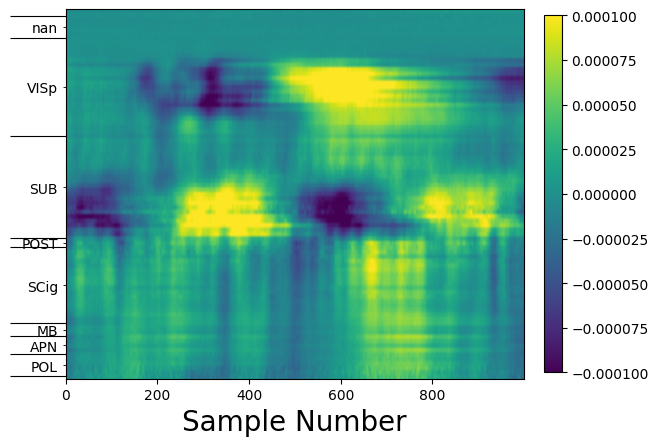

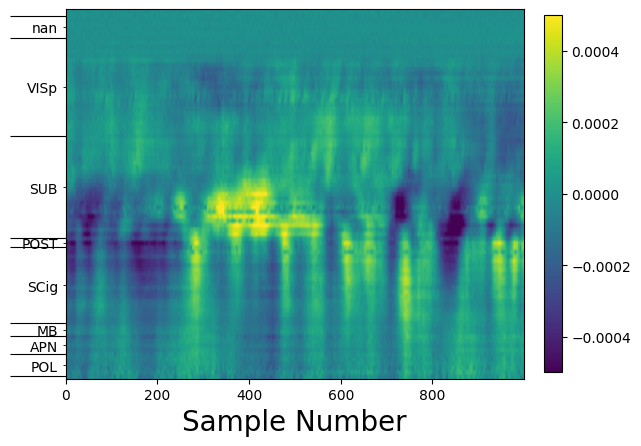

In [65]:
fig, ax = plt.subplots()
im = ax.imshow(aligned_lfp.mean(dim='presentation_id'), aspect='auto', origin='lower', vmin=-1e-4, vmax=1e-4)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1
# time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
# ax.set_xticks(time_label_indices + 0.5)
# ax.set_xticklabels(time_labels)
ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)

plt.show()


## just one
fig, ax = plt.subplots()
im = ax.imshow(aligned_lfp[:,2,:], aspect='auto', origin='lower', vmin=-0.5e-3, vmax=0.5e-3)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1
# time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
# ax.set_xticks(time_label_indices + 0.5)
# ax.set_xticklabels(time_labels)
ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)

plt.show()



(76, 3000)


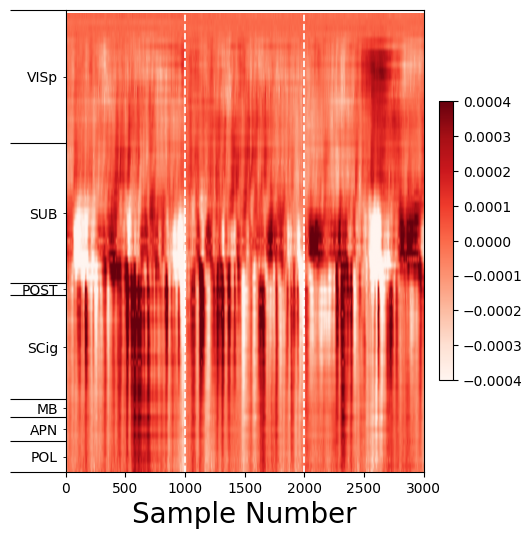

In [66]:
### save data as np arrays 
# sens_max = 74
# probe = 'a'
sens_max = 76
probe = 'c'

lfp_np = aligned_lfp.data
data = np.hstack((lfp_np[:sens_max,0,:], lfp_np[:sens_max,1,:], lfp_np[:sens_max,3,:]))
print(data.shape)

n_t = data.shape[1]
n_s = data.shape[0]


## Plot the numpy array
fig, ax = plt.subplots(figsize = (5,6))
im = ax.imshow(data, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'Reds')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,tot_t*sr, tot_t * 2* sr]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
ax.set_xlim((-1,data.shape[1]))
ax.set_ylim((0,sens_max))

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)
plt.show()



**Applying SHRED on Dataset**

In [67]:
#Importing packages

os.environ["CUDA_VISIBLE_DEVICES"]="0"
SHRED_DIR = os.path.join(HOME_DIR, "neuralSHRED/sindy-shred-main")
import sys 
sys.path.append(SHRED_DIR)

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import sindy_shred


os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [68]:
load_X = data.T

latent_dim = 32
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
import sindy_shred
num_neurons = 3 
lags = 100
test_val_size = int(tot_t*sr - lags)

train_indices = np.arange(0, int(n_t - lags - test_val_size))
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[int(test_val_size/2):test_val_size]
test_indices = valid_test_indices[:int(test_val_size/2)]




In [69]:
# Randomly select the sensors from the CA1 region for probe A (35 - 51) and SUB for probe C (31 - 54)
print(intervals)
print(structure_acronyms)

for k in range(2,3):
    neuron_locations = np.random.choice(np.arange(31, 54), size=num_neurons, replace=False) #### CHANGE HERE
    file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/neuron_loc_{probe}_{k}.npy")
    print(file_path)
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n_t - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False, sindy = False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=0.0,
                                        optimizer="AdamW", thres_epoch=100)

    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mask = np.ones(train_ground_truth.shape[1], dtype=bool)
    mask[neuron_locations] = False
    train_ex = train_recons.T[mask]
    train_gt_ex = train_ground_truth.T[mask]
    mask = np.ones(test_ground_truth.shape[1], dtype=bool)
    mask[neuron_locations] = False
    test_ex = test_recons.T[mask]
    test_gt_ex = test_ground_truth.T[mask]
    mse_train = np.linalg.norm(train_ex - train_gt_ex) / np.linalg.norm(train_gt_ex)
    mse_test = np.linalg.norm(test_ex - test_gt_ex) / np.linalg.norm(test_gt_ex)
    


    file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/train_recons_{probe}_{k}.npy")
    np.save(file_path, train_recons)
    file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/test_recons_{probe}_{k}.npy")
    np.save(file_path, test_recons)
    file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/train_gt_{probe}_{k}.npy")
    np.save(file_path, train_ground_truth)
    file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/test_gt_{probe}_{k}.npy")
    np.save(file_path, test_ground_truth)
    file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/mse_{probe}_{k}.npy")
    np.save(file_path, [mse_train, mse_test])

[ 0  5  9 12 29 31 54 76 81]
['POL' 'APN' 'MB' 'SCig' 'POST' 'SUB' 'VISp' nan]
/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/neuralSHRED/mice/data_output/exp_Bi/flash/neuron_loc_c_2.npy
1 : tensor(0.0718, grad_fn=<AddBackward0>)
2 : tensor(0.0461, grad_fn=<AddBackward0>)
3 : tensor(0.0504, grad_fn=<AddBackward0>)
4 : tensor(0.0482, grad_fn=<AddBackward0>)
5 : tensor(0.0460, grad_fn=<AddBackward0>)
6 : tensor(0.0438, grad_fn=<AddBackward0>)
7 : tensor(0.0422, grad_fn=<AddBackward0>)
8 : tensor(0.0390, grad_fn=<AddBackward0>)
9 : tensor(0.0358, grad_fn=<AddBackward0>)
10 : tensor(0.0296, grad_fn=<AddBackward0>)
11 : tensor(0.0243, grad_fn=<AddBackward0>)
12 : tensor(0.0208, grad_fn=<AddBackward0>)
13 : tensor(0.0190, grad_fn=<AddBackward0>)
14 : tensor(0.0181, grad_fn=<AddBackward0>)
15 : tensor(0.0174, grad_fn=<AddBackward0>)
16 : tensor(0.0159, grad_fn=<AddBackward0>)
17 : tensor(0.0140, grad_fn=<AddBackward0>)
18 : tensor(0.0131, grad_fn=<AddBackward0>)
19 : tensor(0.0127, grad_f

Plotting the Data

[46 47 40]


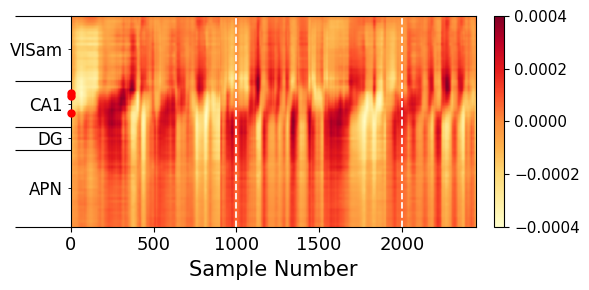

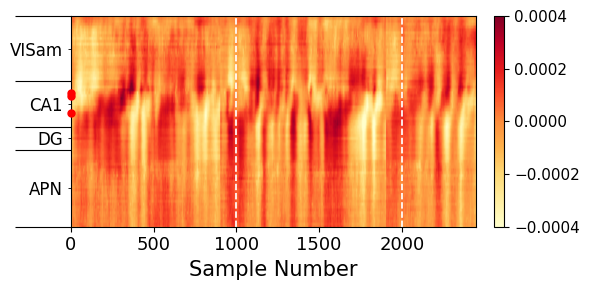

mse [0.35462534 0.63542897]


In [58]:
## Probe A
structure_acronyms = ['APN', 'DG', 'CA1', 'VISam', 'nan']
intervals = [0, 27, 35, 51, 74 ,87]
interval_midpoints = [13.5, 31.0, 43.0, 62.5, 80.5]

### Load the data 
sens_max = 74
probe = 'a'
trial = 2
data_train = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/train_recons_a_{trial}.npy"))
data_test = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/test_recons_a_{trial}.npy"))
data_recon = np.vstack((data_train, data_test))

data_train = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/train_gt_a_{trial}.npy"))
data_test = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/test_gt_a_{trial}.npy"))
data_gt= np.vstack((data_train, data_test))
neuron_loc = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/neuron_loc_a_{trial}.npy"))
mse = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/mse_a_{trial}.npy"))
print(neuron_loc)
## Plot the Reconstruction
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_recon.T, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'YlOrRd')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
    
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,1000, 2000]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
for k in range(len(neuron_loc)):
    ax.plot(-2, neuron_loc[k], 'o', color='red', zorder = 10,  clip_on=False, markersize = 5) 
ax.set_clip_on(False)
ax.set_xlim((-2,data_recon.shape[0]))
ax.set_ylim((0,sens_max))
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, "mice/data_output/figs/lfp_flash_a_recon.png"), transparent = True, dpi = 400)
plt.show()

## Plot the Ground Truth
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_gt.T, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'YlOrRd')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
    
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,1000, 2000]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
for k in range(len(neuron_loc)):
    ax.plot(-2, neuron_loc[k], 'o', color='red', zorder = 10,  clip_on=False, markersize = 5) 
ax.set_clip_on(False)
ax.set_xlim((-2,data_gt.shape[0]))
ax.set_ylim((0,sens_max))
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)
plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, "mice/data_output/figs/lfp_flash_a_gt.png"), transparent = True, dpi = 400)

plt.show()


print('mse', mse)


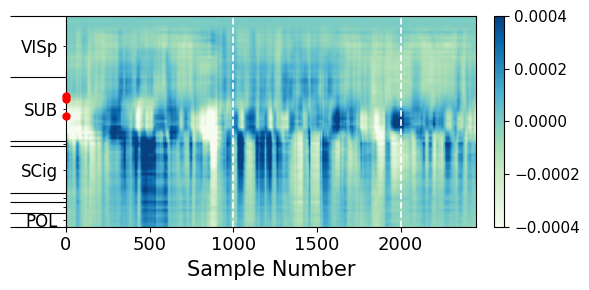

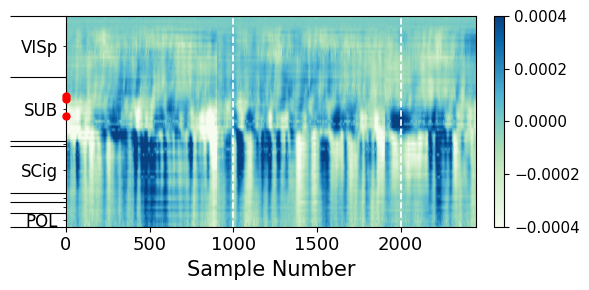

mse [0.40472457 0.9261829 ]


In [76]:
## Probe C
structure_acronyms = ['POL', '', '', 'SCig', '', 'SUB', 'VISp', 'nan']
intervals = [ 0,  5 , 9 ,12 ,29, 31 ,54, 76 ,81]
interval_midpoints = [2.5, 7.0, 10.5, 20.5, 30.0, 42.5, 65.0, 78.5]

### Load the data 
sens_max = 76
probe = 'c'
trial = 2

data_train = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/train_recons_c_{trial}.npy"))
data_test = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/test_recons_c_{trial}.npy"))
data_recon = np.vstack((data_train, data_test))

data_train_gt = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/train_gt_c_{trial}.npy"))
data_test_gt = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/test_gt_c_{trial}.npy"))
data_gt= np.vstack((data_train_gt, data_test_gt))
mse = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Bi/flash/mse_c_{trial}.npy"))
## Plot the Reconstruction
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_recon.T, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'GnBu')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
    
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,1000, 2000]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
for k in range(len(neuron_loc)):
    ax.plot(-2, neuron_loc[k], 'o', color='red', zorder = 10,  clip_on=False, markersize = 5) 
ax.set_clip_on(False)
ax.set_xlim((-2,data_recon.shape[0]))
ax.set_ylim((0,sens_max))
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f"mice/data_output/figs/lfp_flash_c_recon.png"), transparent = True, dpi = 400)
plt.show()

## Plot the Ground Truth
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_gt.T, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'GnBu')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
    
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,1000, 2000]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
for k in range(len(neuron_loc)):
    ax.plot(-2, neuron_loc[k], 'o', color='red', zorder = 10,  clip_on=False, markersize = 5) 
ax.set_clip_on(False)
ax.set_xlim((-2,data_gt.shape[0]))
ax.set_ylim((0,sens_max))
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)
plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f"mice/data_output/figs/lfp_flash_c_gt.png"), transparent = True, dpi = 400)

plt.show()
print('mse',mse)


In [81]:
mask = np.ones(data_train_gt.shape[1], dtype=bool)
mask[neuron_locations] = False
train_ex = data_train.T[mask]
train_gt_ex = data_train_gt.T[mask]
mask = np.ones(data_test_gt.shape[1], dtype=bool)
mask[neuron_locations] = False
test_ex = data_test.T[mask]
test_gt_ex = data_test_gt.T[mask]
mse_train = np.linalg.norm(train_ex - train_gt_ex) / np.linalg.norm(train_gt_ex)
mse_test = np.linalg.norm(test_ex - test_gt_ex) / np.linalg.norm(test_gt_ex)
print('mse', mse_train, mse_test)


mse 0.40472457 0.9261829
